# Pretraining

In [45]:
# Save Model
import torch
import time
import random
from data.swarmset import ContinuingDataset, SwarmDataset
from networks.embedding import NoveltyEmbedding
from networks.archive import DataAggregationArchive
from networks.ensemble import Ensemble
import numpy as np
from scipy import ndimage
import cv2

PRETRAINING = True
target = 0.0001
loss = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ensemble = Ensemble(size=3, output_size=5, lr_series=[1e-4, 1e-4, 1e-4], learning_decay=0.95, decay_step=3, threshold=11.0, weight_decay=1e-4, new_model=True)
ensemble.load_ensemble("full-mini-A")
sampled_dataset = SwarmDataset("data/full-mini", rank=0)

def resizeInput(X, w=200):
    frame = X.astype(np.uint8)
    resized = cv2.resize(frame, dsize=(w, w), interpolation=cv2.INTER_AREA)
    return resized

def translate(img, offset=(10, 10)):
    h, w = img.shape
    xoff, yoff = offset
    if xoff < 0: xpadding = (0, -xoff)
    else: xpadding = (xoff, 0)
    if yoff < 0: ypadding = (0, -yoff)
    else: ypadding = (yoff, 0)
    img = np.pad(img, (xpadding, ypadding))

    if xoff >= 0 and yoff >= 0:
        return img[:w, :w]
    elif xoff < 0 and yoff >= 0:
        return img[-w:, :w]
    elif xoff >= 0 and yoff < 0:
        return img[:w, -w:]
    return img[-w:, -w:]

def zoom_at(img, zoom, coord=None):
    # Adapted from https://stackoverflow.com/questions/69050464/zoom-into-image-with-opencv
    h, w = [ zoom * i for i in img.shape ]
    if coord is None: cx, cy = w/2, h/2
    else: cx, cy = [ zoom*c for c in coord ]
    img = cv2.resize( img, (0, 0), fx=zoom, fy=zoom)
    img = img[ int(round(cy - h/zoom * .5)) : int(round(cy + h/zoom * .5)),
               int(round(cx - w/zoom * .5)) : int(round(cx + w/zoom * .5))]
    return img

def getRandomTransformation(image):
    transformation_choices = ["Rotation", "Blur", "Zoom", "Translate"]
    weights = [0.5, 0.3, 0.0, 0.2]
    # weights = [1.0, 0.0, 0.0, 0.0]
    choice = random.choices(transformation_choices, weights, k=1)[0]
    if choice == "Rotation":
        theta = random.choice([90, 180, 270])
        return ndimage.rotate(image, theta)
    elif choice == "Blur":
        blur = random.choice([0.5, 1.0, 1.5])
        return ndimage.gaussian_filter(image, sigma=blur)
    elif choice == "Zoom":
        # zoom = random.choice([1.06, 1.12, 1.18])
        padding = random.choice([10])
        padded = np.pad(image, padding, mode='constant')
        return resizeInput(padded, 50)
    elif choice == "Translate":
        # offsets = [i for i in range(-10, 10, 2)]
        # offset = (random.choice(offsets), random.choice(offsets))
        offset = (2, 2)
        return translate(image, offset)

def pretraining(data, ensemble, data_cutoff=None, data_size=500):
    if data_cutoff is None:
        data_cutoff = len(data) - 1
    # np.random.seed(0)
    samples = np.random.random_integers(0, data_cutoff, (data_size, 2))
    total_loss = np.array([0.0 for i in range(len(ensemble.ensemble))])
    total_updates = 0
    BATCH_SIZE = 4

    pull_set = [k for k in range(len(samples))]
    random.shuffle(pull_set)
    for index in range(0, len(pull_set), BATCH_SIZE):
        i = pull_set[index]
        if total_updates % 20 == 0:
            print(f"Unsupervised Training.. {(total_updates * BATCH_SIZE * 100) / data_size}")

        AUGMENT_SIZE = 1
        if i + (BATCH_SIZE * AUGMENT_SIZE) >= len(pull_set):
            continue

        temp_losses = np.array([0.0 for _ in ensemble.ensemble])

        anchors = np.array([data[samples[i + (j % AUGMENT_SIZE)][0]][0] for j in range(AUGMENT_SIZE * BATCH_SIZE)])
        positives = np.array([getRandomTransformation(data[samples[i + (j % AUGMENT_SIZE)][0]][0]) for j in range(AUGMENT_SIZE * BATCH_SIZE)])
        negatives = np.array([data[samples[i + (j % AUGMENT_SIZE)][1]][0] for j in range(AUGMENT_SIZE * BATCH_SIZE)])

        anchors = np.expand_dims(anchors, axis=1)
        positives = np.expand_dims(positives, axis=1)
        negatives = np.expand_dims(negatives, axis=1)

        losses = ensemble.train_batch(anchors, positives, negatives)
        temp_losses += losses

        total_loss += temp_losses
        total_updates += 1

    return total_loss, total_updates

t_1 = time.time()
if PRETRAINING:
    epochs = 0
    loss_history = []
    while loss > target:
        losses, total_updates = pretraining(sampled_dataset, ensemble, data_cutoff=None, data_size=2000)
        average_loss = losses / total_updates
        lr = ensemble.evaluate_lr(average_loss)
        locale_loss = sum(average_loss) / len(average_loss)
        loss_history.append(locale_loss)
        loss = (sum(loss_history[-3:]) / 3) if len(loss_history) > 3 else 50
        print(f"LR: {lr}")
        print(f"Losses: {average_loss}")
        print(f"Epoch {epochs}, loss: {locale_loss}, windowed_loss: {loss}")
        epochs += 1

print(f"Total Pre-training Time: {time.time() - t_1}")
ensemble.save_ensemble(f"{int(time.time())}")

/tmp/ipykernel_1577473/597914256.py:79: DeprecationWarning: This function is deprecated. Please call randint(0, 9999 + 1) instead
  samples = np.random.random_integers(0, data_cutoff, (data_size, 2))


Unsupervised Training.. 0.0
Unsupervised Training.. 4.0
Unsupervised Training.. 8.0
Unsupervised Training.. 12.0
Unsupervised Training.. 16.0
Unsupervised Training.. 20.0
Unsupervised Training.. 24.0
Unsupervised Training.. 28.0
Unsupervised Training.. 32.0
Unsupervised Training.. 36.0
Unsupervised Training.. 40.0
Unsupervised Training.. 44.0
Unsupervised Training.. 48.0
Unsupervised Training.. 52.0
Unsupervised Training.. 56.0
Unsupervised Training.. 60.0
Unsupervised Training.. 64.0
Unsupervised Training.. 68.0
Unsupervised Training.. 72.0
Unsupervised Training.. 76.0
Unsupervised Training.. 80.0
Unsupervised Training.. 84.0
Unsupervised Training.. 88.0
Unsupervised Training.. 92.0
Unsupervised Training.. 96.0
LR: [[0.0001], [0.0001], [0.0001]]
Losses: [0.20592165 0.19463463 0.3588306 ]
Epoch 0, loss: 0.25312895844917577, windowed_loss: 50
Unsupervised Training.. 0.0
Unsupervised Training.. 4.0
Unsupervised Training.. 8.0
Unsupervised Training.. 12.0
Unsupervised Training.. 16.0
Unsu

KeyboardInterrupt: 

In [15]:
ensemble.save_ensemble(f"{int(time.time())}")

# Supervised Learning

In [57]:
import torch
import time
from data.swarmset import ContinuingDataset, SwarmDataset
from networks.embedding import NoveltyEmbedding
from networks.archive import DataAggregationArchive
from networks.ensemble import Ensemble
import numpy as np
from scipy import ndimage
import random
classification_set = {
    0 : [],
    1 : [],
    2 : []
}

PRETRAINING = True
target = 0.01
loss = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ensemble = Ensemble(size=3, output_size=5, lr_series=[15e-4, 15e-4, 15e-4], learning_decay=0.9, decay_step=4, threshold=6.0, weight_decay=1e-4)
ensemble.load_ensemble("toy-surgery")
sampled_dataset = SwarmDataset("data/toy", rank=0)
data = sampled_dataset

# Separate
for i in range(len(sampled_dataset)):
    _class = sampled_dataset[i][1][0]
    classification_set[_class].append(i)

# Pair Up
SAMPLES = 3000
triplets = []
for i in range(SAMPLES):
    classA = random.randint(0, 2)
    classB = random.randint(0, 2)

    anchor = random.choice(classification_set[classA])
    positive = random.choice(classification_set[classA])
    negative = random.choice(classification_set[classB])
    triplet = [anchor, positive, negative]
    if triplet not in triplets:
        triplets.append(triplet)

# Training
BATCH_SIZE = 5
EPOCH_DATA_LIM = 500
while loss > target:
    total_updates = 0
    total_loss = np.array([0.0 for i in range(len(ensemble.ensemble))])
    random.shuffle(triplets)
    temp_triplets = triplets[:EPOCH_DATA_LIM]
    for i in range(0, len(temp_triplets), BATCH_SIZE):
        if total_updates % 10 == 0:
            print(f"Unsupervised Training.. {(total_updates * BATCH_SIZE * 100) / len(temp_triplets)}")

        if i + BATCH_SIZE > len(triplets):
            break

        anchors = np.array([data[temp_triplets[i + j][0]][0] for j in range(BATCH_SIZE)])
        positives = np.array([data[temp_triplets[i + j][1]][0] for j in range(BATCH_SIZE)])
        negatives = np.array([data[temp_triplets[i + j][2]][0] for j in range(BATCH_SIZE)])

        anchors = np.expand_dims(anchors, axis=1)
        positives = np.expand_dims(positives, axis=1)
        negatives = np.expand_dims(negatives, axis=1)

        losses = ensemble.train_batch(anchors, positives, negatives)
        total_loss += losses
        total_updates += 1

    l = total_loss / total_updates
    lr = ensemble.evaluate_lr(l)
    loss = sum(l) / len(l)
    print(f"Losses: {l}, LR: {lr}, Loss: {loss}")

print("Complete!")
# ensemble.save_ensemble(f"{int(time.time())}")

Unsupervised Training.. 0.0
Unsupervised Training.. 10.0
Unsupervised Training.. 20.0
Unsupervised Training.. 30.0
Unsupervised Training.. 40.0
Unsupervised Training.. 50.0
Unsupervised Training.. 60.0
Unsupervised Training.. 70.0
Unsupervised Training.. 80.0
Unsupervised Training.. 90.0
Losses: [11.54286151 11.83442778 12.2440053 ], LR: [[0.0015], [0.0015], [0.0015]], Loss: 11.873764862219494
Unsupervised Training.. 0.0
Unsupervised Training.. 10.0
Unsupervised Training.. 20.0
Unsupervised Training.. 30.0
Unsupervised Training.. 40.0
Unsupervised Training.. 50.0
Unsupervised Training.. 60.0
Unsupervised Training.. 70.0
Unsupervised Training.. 80.0
Unsupervised Training.. 90.0
Losses: [10.03131055 10.08217909 10.07937417], LR: [[0.0015], [0.0015], [0.0015]], Loss: 10.064287937482199
Unsupervised Training.. 0.0
Unsupervised Training.. 10.0
Unsupervised Training.. 20.0
Unsupervised Training.. 30.0
Unsupervised Training.. 40.0
Unsupervised Training.. 50.0
Unsupervised Training.. 60.0
Unsu

In [58]:
ensemble.save_ensemble(f"{int(time.time())}")

# Visualize Embeddings with Classes

In [41]:
import torch
import time
from data.swarmset import ContinuingDataset, SwarmDataset
from networks.embedding import NoveltyEmbedding
from networks.archive import DataAggregationArchive
from networks.ensemble import Ensemble
import numpy as np
from scipy import ndimage
import random
from sklearn.manifold import TSNE

PRETRAINING = True
ENSEMBLE_MEMBER = 1
target = 0.01
loss = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ensemble = Ensemble(size=3, output_size=5, lr_series=[15e-4, 15e-4, 15e-4], learning_decay=0.7, decay_step=1, threshold=9.0, weight_decay=1e-4, new_model=True)
ensemble.load_ensemble("full-mini-B")
# ensemble.load_ensemble("tiny-toy-C")
# ensemble.load_ensemble("toy-HIL-forced")
ensemble.eval_mode()
sampled_dataset = SwarmDataset("data/full-mini", rank=0)
data = sampled_dataset

embeddings = []
classes = []
# for i in range(len(data)):
for i in range(110):
    image, _class = sampled_dataset[i][0], sampled_dataset[i][1][0]
    image = np.expand_dims(image, axis=0)
    embed = ensemble.ensemble[ENSEMBLE_MEMBER].forward(torch.tensor(image, device=device, dtype=torch.float))
    embed = embed.detach().cpu().squeeze(dim=0).numpy()
    embeddings.append(embed)
    classes.append(_class)

embeddings = np.array(embeddings)

In [42]:
reduced = TSNE(
    n_components=2,
    learning_rate="auto",
    init="pca",
    perplexity=40,
    early_exaggeration=1
).fit_transform(embeddings)

/home/connor/Desktop/research/SwarmNoveltyNetwork/.env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


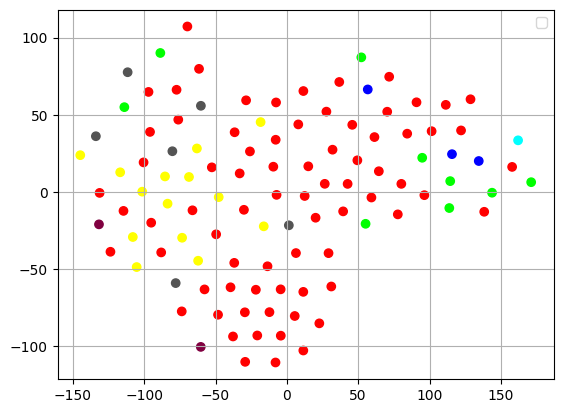

In [43]:
import matplotlib.pyplot as plot
import os

def CSVLineToVec(line):
    line_list = line.strip().replace("\n", "").split(",")
    float_list = []
    for i in line_list:
        float_list.append(float(i))
    float_list = np.array(float_list)
    return float_list

color_classes = {
    -1: [0.33, 0.33, 0.33],
    0: [1, 0, 0],
    1: [0, 1, 0],
    2: [0, 0, 1],
    3: [0, 1, 1],
    4: [1, 1, 0],
    5: [0.5, 0, 0.25]
}

label_classes = {
    -1: "Unlabeled",
    0: "Random",
    1: "Cyclic Pursuit",
    2: "Milling",
    3: "Aggregation",
    4: "Dispersal",
    5: "Wall Following"
}

lim = len(reduced)
classes = [-1 for i in range(lim)]

OUT = "data/oracle"
with open(os.path.join(OUT, "original-hand-labeled-classes.txt"), "r") as f:
    lines = f.readlines()
    for line in lines:
        triplet = CSVLineToVec(line)
        classes[int(triplet[0])] = int(triplet[1])

x = [reduced[i][0] for i in range(lim)]
y = [reduced[i][1] for i in range(lim)]
colors = [color_classes[classes[i]] for i in range(lim)]
labels = [label_classes[classes[i]] for i in range(lim)]
plot.grid(True)
plot.scatter(x, y, c=colors)
plot.legend()

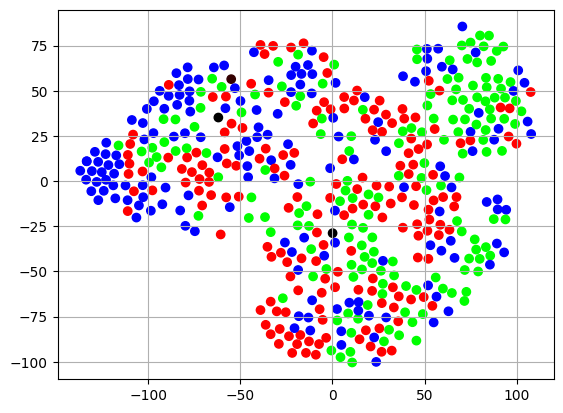

In [102]:
import os

def CSVLineToVec(line):
    line_list = line.strip().replace("\n", "").split(",")
    float_list = []
    for i in line_list:
        float_list.append(float(i))
    float_list = np.array(float_list)
    return float_list

color_classes = {
    0: [1, 0, 0],
    1: [0, 1, 0],
    2: [0, 0, 1],
}

label_classes = {
    0: "Circles",
    1: "Triangles",
    2: "Squares",
}

triples = []
ensemble.eval_mode()
OUT = "data/toy-oracle"
with open(os.path.join(OUT, "triplets.txt"), "r") as f:
    lines = f.readlines()
    for line in lines:
        triplet = CSVLineToVec(line)
        triples.append([int(triplet[0]), int(triplet[1]), int(triplet[2])])

target_triplet = triples[13]
lim = 500
x = [reduced[i][0] for i in range(lim)]
y = [reduced[i][1] for i in range(lim)]
colors = [color_classes[classes[i]] for i in range(lim)]
labels = [label_classes[classes[i]] for i in range(lim)]

# colors[target_triplet[0]] = [0, 0, 0]
# colors[target_triplet[1]] = [0, 0, 0]
# colors[target_triplet[2]] = [0.2, 0, 0]

plot.grid(True)
plot.scatter(x, y, c=colors)